# Deep Learning Based Statistical Downscaling vs. Bias Correction
### In this study, EC-Earth3 precipitation is downscaled to APHRODITE's resolution (0.25$^\circ$) using dl4ds architecture (Res-NET). On top of EC-Earth's precipitation, specific humidity, zonal wind, meridonal wind (at 4 different zeo-potential heigth), sea surface pressure level, air temperature, etc. are taken into account as predictors. Alongside, grid-based liner bias correction is also carried out. 

### Import Required Modules

In [1]:
import numpy as np
import tensorflow as tf
#import keras
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import xarray as xr
import gcsfs
import os
import datetime

In [3]:
path = './'
os.getcwd()

'D:\\Python\\myvenv\\ML-project'

In [4]:
# read csv file housing CMIP6 datasets
gcmlists = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
gcmlists.head()  

activity_id institution_id     source_id       experiment_id member_id  \
0  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
1  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
2  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
3  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
4  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   

  table_id variable_id grid_label  \
0     Amon          ps         gn   
1     Amon        rsds         gn   
2     Amon        rlus         gn   
3     Amon        rlds         gn   
4     Amon         psl         gn   

                                              zstore  dcpp_init_year   version  
0  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
1  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
2  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
3  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
4  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706

In [5]:
gcmlists[gcmlists.source_id=='EC-Earth3'].variable_id.unique()

array(['volo', 'mlotst', 'msftbarot', 'orog', 'masso', 'rlus', 'hfss',
       'uo', 'rlds', 'mrsos', 'mrso', 'hus', 'hur', 'sivol', 'siconca',
       'vo', 'hfls', 'prsn', 'prw', 'snw', 'wap', 'va', 'snc', 'rlutcs',
       'rsds', 'tasmin', 'bigthetao', 'mrros', 'ua', 'rsutcs', 'basin',
       'deptho', 'rsut', 'rsus', 'rsdt', 'huss', 'hurs', 'evspsbl', 'zg',
       'tauv', 'tauu', 'tasmax', 'ta', 'pr', 'wo', 'obvfsq', 'prc',
       'bigthetaoga', 'umo', 'tosga', 'zostoga', 'mrro', 'clwvi', 'clivi',
       'rlut', 'pbo', 'sftof', 'ts', 'sfcWind', 'psl', 'uas', 'areacello',
       'hfgeou', 'sos', 'tos', 'zos', 'ps', 'siconc', 'wfo', 'vmo',
       'thkcello', 'ficeberg', 'fsitherm', 'tas', 'rtmt', 'clt',
       'thetaoga', 'thetao', 'tauuo', 'sisnthick', 'sitemptop', 'sithick',
       'siu', 'siv', 'sndmasssnf', 'tauvo', 'hfbasin', 'hfds', 'sfdsi',
       'so', 'soga', 'simass', 'sisnmass', 'vas', 'sfcWindmax', 'hursmin',
       'sitimefrac', 'hursmax', 'slthick', 'sispeed', 'ta850', 'm

In [6]:
# df_hist = gcmlists.query("source_id=='EC-Earth3' & table_id == 'Amon' & " +\
#     "variable_id in ['pr', 'ta850', 'tasmax', 'tasmin','hurs','huss','psl', 'ua' ] & experiment_id == 'historical' & member_id == 'r1i1p1f1'")
# df_hist
df_hist = gcmlists.query("source_id=='EC-Earth3' & table_id=='day' & " +\
    "variable_id in ['pr', 'tasmax', 'tasmin','hurs','huss','psl', 'ua', 'tas', 'va', 'zg', 'hus', 'ta', 'ts' ] & experiment_id == 'historical' & member_id == 'r1i1p1f1'")
df_hist

activity_id       institution_id  source_id experiment_id member_id  \
425394        CMIP  EC-Earth-Consortium  EC-Earth3    historical  r1i1p1f1   
425401        CMIP  EC-Earth-Consortium  EC-Earth3    historical  r1i1p1f1   
425407        CMIP  EC-Earth-Consortium  EC-Earth3    historical  r1i1p1f1   
425408        CMIP  EC-Earth-Consortium  EC-Earth3    historical  r1i1p1f1   
425411        CMIP  EC-Earth-Consortium  EC-Earth3    historical  r1i1p1f1   
425415        CMIP  EC-Earth-Consortium  EC-Earth3    historical  r1i1p1f1   
425416        CMIP  EC-Earth-Consortium  EC-Earth3    historical  r1i1p1f1   
425488        CMIP  EC-Earth-Consortium  EC-Earth3    historical  r1i1p1f1   
425490        CMIP  EC-Earth-Consortium  EC-Earth3    historical  r1i1p1f1   
425492        CMIP  EC-Earth-Consortium  EC-Earth3    historical  r1i1p1f1   
425493        CMIP  EC-Earth-Consortium  EC-Earth3    historical  r1i1p1f1   

       table_id variable_id grid_label  \
425394      day          pr         gr   
425401      day         psl         gr   
425407      day        huss         gr   
425408      day         hus         gr   
425411      day        hurs         gr   
425415      day         tas         gr   
425416      day      tasmax         gr   
425488      day          zg         gr   
425490      day          va         gr   
425492      day          ua         gr   
425493      day      tasmin         gr   

                                                   zstore  dcpp_init_year  \
425394  gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...             NaN   
425401  gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...             NaN   
425407  gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...             NaN   
425408  gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...             NaN   
425411  gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...             NaN   
425415  gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...             NaN   
425416  gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...             NaN   
425488  gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...             NaN   
425490  gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...             NaN   
425492  gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...             NaN   
425493  gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...             NaN   

         version  
425394  20200310  
425401  20200310  
425407  20200310  
425408  20200310  
425411  20200310  
425415  20200310  
425416  20200310  
425488  20200310  
425490  20200310  
425492  20200310  
425493  20200310

### Description of code of the following cell:
-The provided code uses the Dask library to perform parallel computation on large arrays of climate data. It imports Dask and the ProgressBar function from the dask.diagnostics module. It then sets up lists of strings named "predictors" and "predictants," containing the names of variables used in the analysis.

-The code starts by defining a variable "zstore_hist" as the first element of the 'zstore' column in a DataFrame "df_hist." It filters "df_hist" based on the condition that the 'variable_id' column is equal to 'ua'. This suggests that "zstore_hist" contains a file location associated with the 'ua' (wind) variable data.

-Two empty dictionaries, "pred_df" and "output_df," and a list of integers named "pl" are created.

-The code opens a context manager with ProgressBar() to display the progress of the computation. This is useful to track the computation's progress and completion.

-The code enters a for loop iterating over the elements of the "predictors" list. Within the loop, it prints the current predictor variable name.

-It then reassigns "zstore_hist" to the first element of the 'zstore' column in "df_hist" filtered by the condition that the 'variable_id' column is equal to the current predictor variable. This suggests that "zstore_hist" contains the file location associated with the current predictor variable.

-A connection to a cloud storage file system using gcsfs is set up, and a mapper object for "zstore_hist" is obtained.

-The code opens a zarr dataset using the xr.open_zarr() method and selects a specific time slice from the "time" dimension. It also applies a transformation to the 'lon' coordinate to make the values range from -180 to 180.

-The dataset is sorted by 'lon', and a slice is selected from the 'lon' and 'lat' dimensions.

-The code then checks if the current predictor variable is not in a list of three values. If it is not, the data at each pressure level is opened and saved to a new netCDF file. Otherwise, if the predictor variable is in the list, the entire data is saved to a netCDF file.

In [ ]:
import dask
from dask.diagnostics import ProgressBar
predictors =['hus','psl', 'ua', 'va', 'zg','pr','tas' ] #'ta' missing in the csv file
#predictors = ['ua','va', 'zg', 'pr', 'tas']
predictants = ['pr', 'tasmax','tasmin']
zstore_hist = df_hist[df_hist.variable_id=='ua'].zstore.values[0]

pred_df= {}
output_df= {}
pl= [25000, 50000, 70000, 85000]

#with dask.config.set(**{'array.slicing.split_large_chunks': False}):
with ProgressBar():
    for predictor in predictors:
        print(predictor)
        zstore_hist = df_hist[df_hist.variable_id==predictor].zstore.values[0]
        gcs = gcsfs.GCSFileSystem(token='anon')
        mapper = gcs.get_mapper(zstore_hist)
        temp_df = xr.open_zarr(mapper, consolidated = True).sel(time= slice('2015-01-01' ,'2100-12-31'))
        temp_df.coords['lon']= (temp_df.coords['lon']+180)%360 - 180
        # separate each ds for each pressure levels
        temp_df = temp_df.sortby(temp_df.lon).sel(lon=slice(80,120), lat= slice(0,30))

        if predictor not in ['psl', 'pr','tas']:
            elev_wise_df= temp_df[predictor].to_dataset(dim='plev')
            #print(elev_wise_df)
            #pred_df[predictor] = [elev_wise_df[var].values for var in elev_wise_df.variables if var in pl]
            [elev_wise_df.rename({var: str(var)})[str(var)].compute().to_netcdf(path+'ssp585/'+f'{predictor}_{int(var)}.nc') for i, var in enumerate(elev_wise_df.variables) if var in pl]
        else:
             # pred_df[predictor]= [temp_df[predictor]].load().to_netcdf(path+f'{var}.nc')]
            [temp_df[predictor].load().to_netcdf(path+'ssp585/'+f'{predictor}.nc')]
 
  # # load xarray datasets for predictants
  # for predictant in predictants:
  #   zstore_hist_prdn = df_hist[df_hist.variable_id==predictant].zstore.values[0]
  #   gcs = gcsfs.GCSFileSystem(token='anon')
  #   mapper = gcs.get_mapper(zstore_hist_prdn)
  #   temp_df_pdn = xr.open_zarr(mapper, consolidated = True).sel(time= slice('1985-01-01','2014-12-31'))
  #   temp_df_pdn.coords['lon']= (temp_df_pdn.coords['lon']+180)%360 - 180
  #   output_df[predictant] = temp_df_pdn.sortby(temp_df_pdn.lon).sel(lon=slice(80,120), lat= slice(0,30))

<AxesSubplot: >

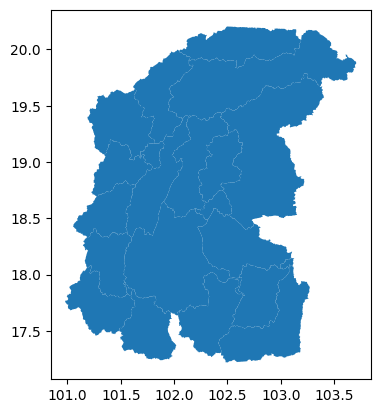

In [8]:
import geopandas as gpd
url = "http://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_110m_land.geojson"
df =gpd.read_file(url)

namngum= gpd.read_file('./Namngum/subs1.shp').to_crs('EPSG:4326')
namngum.plot()

# df 

### Read APHRODITE preciptation

In [9]:
# read aphrodite data and scale it to ECearth 
output_ds = [xr.open_dataset(path+'Aphroma_SEA.nc').precip / 86400.]
output_ds[0].shape

(10957, 120, 160)

### Select predictors at specified pressure levels

In [10]:
#read all nc files

predictors =['hus','psl', 'ua', 'va', 'zg','pr','tas' ]
pl= [25000, 50000, 70000, 85000]
pred_ds = {predictor: [xr.open_dataset(path+'historical/'+f'{predictor}_{str(ple)}.nc')[str(float(ple))] for ple in pl] 
           if predictor not in ['psl', 'pr', 'tas']
           else [xr.open_dataset(path+'historical/'+f'{predictor}.nc')[predictor]]
           for predictor in predictors
           }

In [11]:
import dl4ds as dds
import ecubevis as ecv
import climetlab as cml


In [12]:
# define lats and longs to make ecearth3's resolution to 100km

lats=np.arange(0.125, pred_ds['hus'][0].lat.max(), 1)
lons=np.arange(80.125, pred_ds['hus'][0].lon.max(), 1)


### Prepare train, validation and test dataset

[10604  5030  5144 ...  7026   533  9361]
[10604  5030  5144 ...  9979  7031  2432]
[3663 1912 9944 ... 3777 7656 6276]
10957
Variable name: 25000.0
Dimensionality: 3D
Shape: (2, 30, 40)


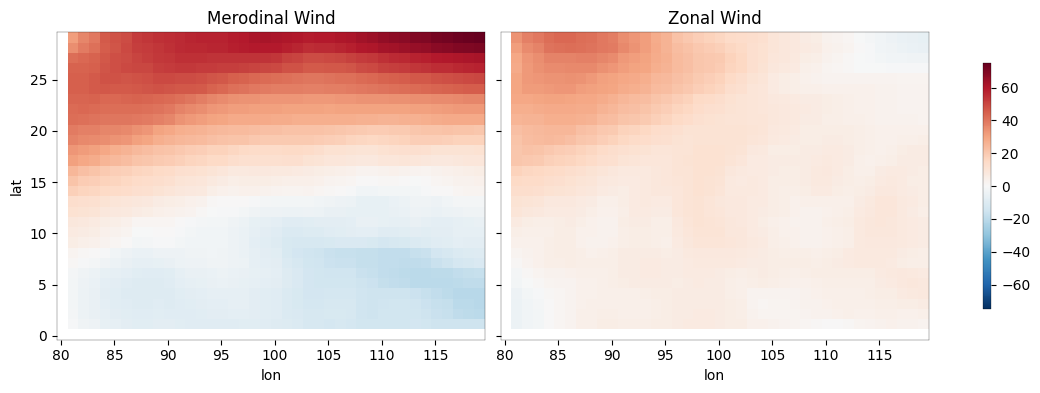

In [13]:

# Transpose all the predictors in the shape of (time, lon, lat, channel) as required by the dl4ds 

import random
random.seed(10)

# split the predictors into train, valid and test set and interpolate ECEarth predictors to aphrodite resolution

idx = np.arange(0, pred_ds['psl'][0].shape[0])

random.shuffle(idx)
print(idx)
train_idx = idx[: int(len(idx)*0.6)]
print(train_idx)
valid_idx= idx[len(train_idx): int(len(idx)*0.8)]
print(valid_idx)
test_idx = idx[ len(train_idx)+len(valid_idx) :]
print(len(train_idx)+ len(valid_idx)+ len(test_idx))
pred_train= {key: [df.isel(time= train_idx).interp(lat= lats, lon=lons, method='nearest') for df in dfs] for key, dfs in pred_ds.items()}
pred_valid=  {key: [df.isel(time= valid_idx).interp(lat= lats, lon= lons, method='nearest') for df in dfs] for key, dfs in pred_ds.items()}
pred_test =  {key: [df.isel(time= test_idx).interp(lat= lats, lon= lons, method='nearest') for df in dfs] for key, dfs in pred_ds.items()}
ecv.plot((pred_train['ua'][0].isel(time=0), pred_train['va'][0].isel(time= 0)), subplot_titles= ('Merodinal Wind', 'Zonal Wind'))

Variable name: precip
Dimensionality: 3D
Shape: (2, 120, 160)


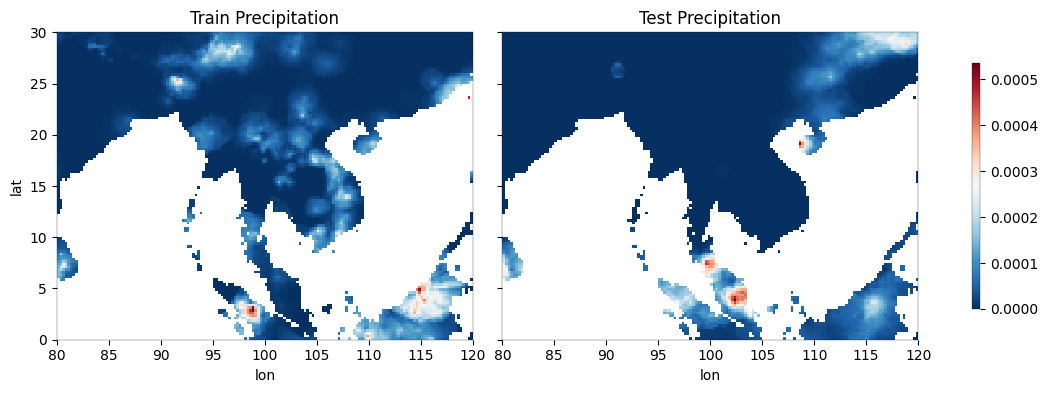

In [14]:
y_train= output_ds[0].isel(time= train_idx)
y_valid=output_ds[0].isel(time= valid_idx)
y_test=  output_ds[0].isel(time= test_idx)
ecv.plot((y_valid[5], y_test[5]), subplot_titles= ('Train Precipitation', 'Test Precipitation'))

Variable name: 25000.0
Dimensionality: 3D
Shape: (2, 30, 40)


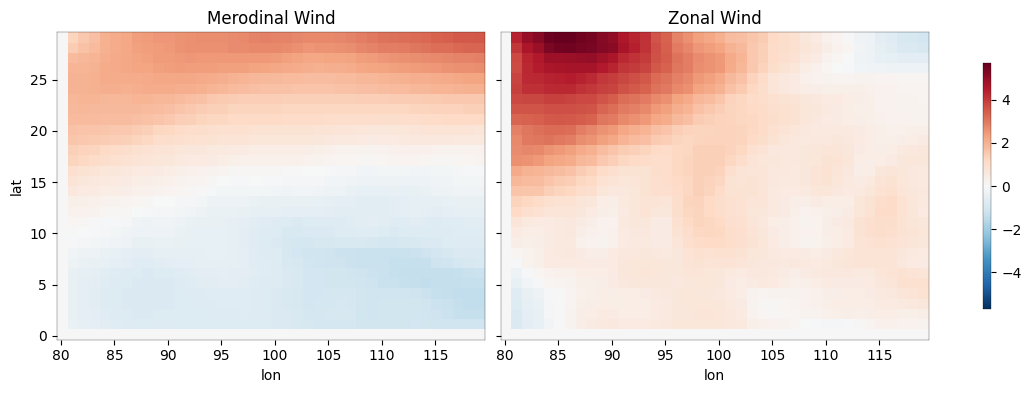

In [15]:
import dask
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    # scale the dataarray
    x_train={}
    x_valid={}
    x_test={}

    for param, da in pred_train.items():
        #print(da)
        pred_train_scaler = dds.StandardScaler(axis=None)
        x_train[param] = [ pred_train_scaler.fit(da).transform(da) if da in ['psl','pr', 'ta']
                     else [pred_train_scaler.fit(da_indv).transform(da_indv) for da_indv in da ]

                     ][0]

    for param, da in pred_valid.items():
        pred_valid_scaler = dds.StandardScaler(axis=None)
        x_valid[param] = [ pred_valid_scaler.fit(da).transform(da) if da in ['psl','pr', 'ta']
                     else [pred_valid_scaler.fit(da_indv).transform(da_indv) for da_indv in da ]
                     ][0]

    for param, da in pred_test.items():
        pred_test_scaler = dds.StandardScaler(axis=None)
        x_test[param] = [ pred_test_scaler.fit(da).transform(da) if da in ['psl','pr', 'ta']
                     else [pred_test_scaler.fit(da_indv).transform(da_indv) for da_indv in da ]
                     ][0]

    precip_scaler= dds.StandardScaler(axis=None)
    precip_scaler.fit(pred_ds['pr'][0])
    ecv.plot((x_train['ua'][0][0], x_train['va'][0][0]), subplot_titles= ('Merodinal Wind', 'Zonal Wind'))

In [16]:
x_train= {key : [da.expand_dims(dim='channel', axis=-1) for da in value] if key not in ['psl', 'pr', 'tas'] else [value[0].expand_dims(dim='channel', axis=-1)] for key, value in x_train.items()}
x_valid= {key : [da.expand_dims(dim='channel', axis=-1) for da in value] if key not in ['psl', 'pr', 'tas'] else [value[0].expand_dims(dim='channel', axis=-1)] for key, value in x_valid.items()}
x_test= {key : [da.expand_dims(dim='channel', axis=-1) for da in value] if key not in ['psl', 'pr', 'tas'] else [value[0].expand_dims(dim='channel', axis=-1)] for key, value in x_test.items()}

In [17]:
y_scaler=  dds.StandardScaler(axis=None)
y_scaler.fit(y_train)
y_train = y_scaler.transform(y_train)
y_valid= y_scaler.transform(y_valid)
y_scaler_test= y_scaler.fit(y_test)
y_test= y_scaler_test.transform(y_test)

In [18]:
y_train = y_train.expand_dims(dim='channel', axis=-1)
y_valid = y_valid.expand_dims(dim='channel', axis=-1)
y_test = y_test.expand_dims(dim='channel', axis=-1)


In [19]:
print(x_train['psl'][0].shape , y_train.shape)
print(x_valid['psl'][0].shape, y_valid.shape)
print(x_test['psl'][0].shape, y_test.shape)

(6574, 30, 40, 1) (6574, 120, 160, 1)
(2191, 30, 40, 1) (2191, 120, 160, 1)
(2192, 30, 40, 1) (2192, 120, 160, 1)


In [20]:
import itertools

#flatten dictionary values (nested lists ) to single list of all arrays
train_pred_list= list(itertools.chain(*x_train.values()))
valid_pred_list= list(itertools.chain(*x_valid.values()))
test_pred_list= list(itertools.chain(*x_test.values()))
print(len(train_pred_list), len(test_pred_list))

19 19


In [ ]:
# train_pred_list = []
# valid_pred_list=[]
# test_pred_list=[]

# names= ['train', 'valid', 'test']

# for name in names:

#   for var in eval(f'x_{name}').keys():
#     if var != 'psl':
#       for i in range(4):
#         eval(f'{name}_pred_list').append(x_train[var][:, :, :, i][:,:,:,np.newaxis])
#     else:
#       eval(f'{name}_pred_list').append(x_train[var])

# # [ x_train[var] for var in x_train.keys()]
# # valid_pred_list = [ x_valid[var] for var in x_valid.keys()]
# # test_pred_list = [x_test[var] for var in x_test.keys()]
# for dels in  train_pred_list:
#   print(dels.shape)

In [ ]:
print(exec('x_train'))

### Description of model parameters and architecture used in downlscaling 

The provided code uses the DeepDS (Deep Downscaling) library to train a deep learning model for downscaling low-resolution climate data. It performs the following steps:

1. Defines a dictionary named "ARCH_PARAMS" containing various architecture parameters for the model. These parameters specify the number of filters and blocks in the model, the type of normalization and dropout to use, the activation function, and whether to include attention and a local conditioning layer.

2. Creates an instance of the "SupervisedTrainer" class from the DeepDS library and passes several arguments to it. These arguments include the backbone of the model set to 'resnet', the upsampling method set to 'spc', and data for training, validation, and testing.

3. The data for low-resolution is provided as 'data_train_lr', 'data_val_lr', and 'data_test_lr', while the high-resolution data for training, validation, and testing is provided as 'data_train', 'data_val', and 'data_test' respectively.

4. Additional parameters such as the downscaling scale, time window, and static variables are passed as 'scale', 'time_window', and 'static_vars' respectively.

5. The predictors for training, validation, and testing are provided as 'predictors_train', 'predictors_val', and 'predictors_test'.

6. The code sets various hyperparameters like the interpolation method, batch size, number of epochs, learning rate, learning rate decay, early stopping, patience, minimum delta, save path, show plot, verbose, device, and the architecture parameters.

7. Finally, the .run() method is called on the trainer object to start the training process. The model is trained using the specified parameters, and during training, the loss is plotted, and progress information is printed to the console. Additionally, the trained model is saved to the specified save path.

List of devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Number of devices: 1
Global batch size: 64
--------------------------------------------------------------------------------
Starting time: 2023-07-31 14:12:13
--------------------------------------------------------------------------------
Model: "resnet_spc"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                     Param #           Connected to                                      
 input_1 (InputLayer)                            [(None, 30, 40, 20)]             0                 []                                                
                                                                                                                                                      
 conv2d (Conv2D)                                 (No

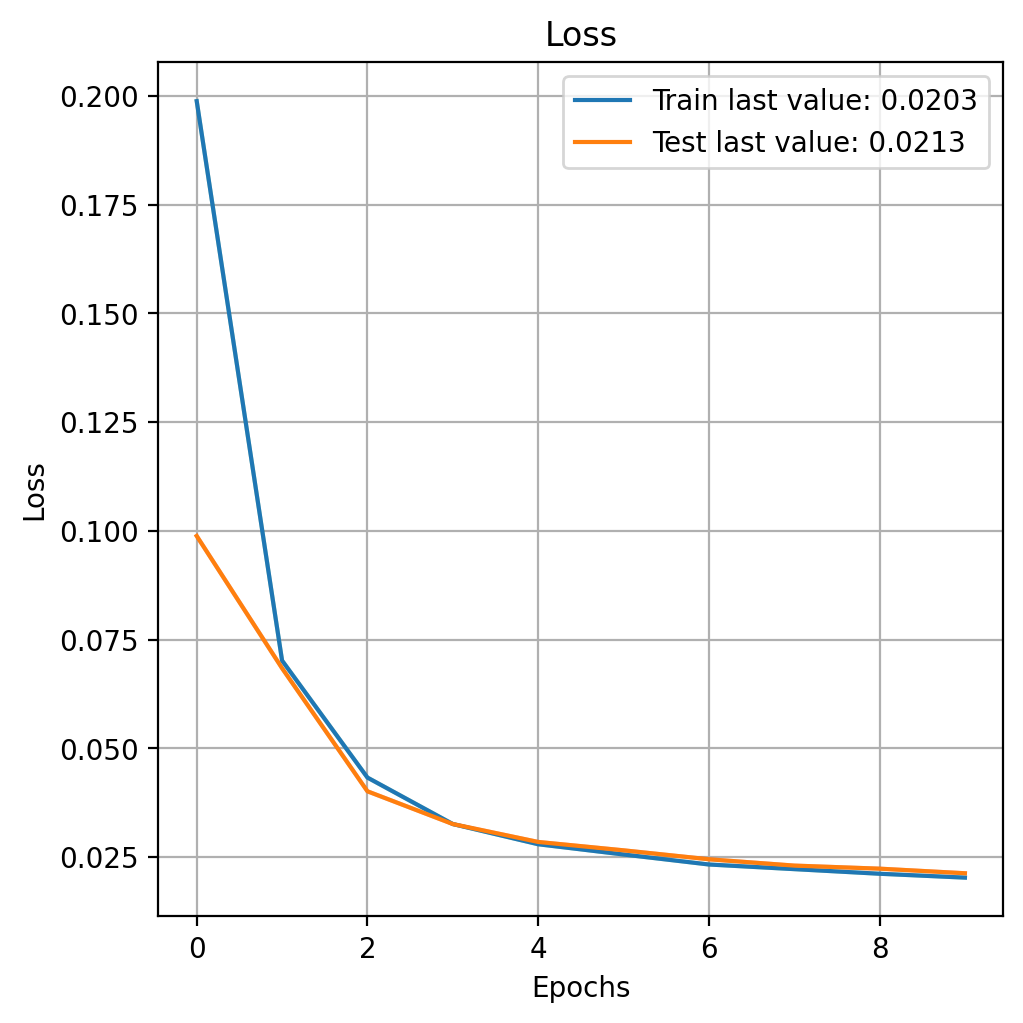

In [21]:
# set up resnet model and run the model
ARCH_PARAMS = dict(n_filters=8,
                   n_blocks=8,
                   normalization=None,
                   dropout_rate=0.0,
                   dropout_variant='spatial',
                   attention=False,
                   activation='relu',
                   localcon_layer=True)

trainer = dds.SupervisedTrainer(
    backbone='resnet',
    upsampling='spc', 
    data_train=y_train, 
    data_val=y_valid,
    data_test=y_test,
    data_train_lr=None, # here you can pass the LR dataset for training with explicit paired samples
    data_val_lr=None, # here you can pass the LR dataset for training with explicit paired samples
    data_test_lr=None, # here you can pass the LR dataset for training with explicit paired samples
    scale=4,
    time_window=None, 
    static_vars=None,
    predictors_train=train_pred_list,
    predictors_val=valid_pred_list,
    predictors_test=test_pred_list,
    interpolation='inter_area',
    patch_size=None, 
    batch_size=64, 
    loss='mse',
    epochs=10, 
    steps_per_epoch=None, 
    validation_steps=None, 
    test_steps=None, 
    learning_rate=(1e-3, 1e-4), lr_decay_after=1e4,
    early_stopping=True, patience=6, min_delta=0, 
    save=True, 
    save_path=path,
    show_plot=True, verbose=True, 
    device='CPU',
    **ARCH_PARAMS)

trainer.run()

In [22]:
#trainer= tf.saved_model.load(path+'resnet_spc/')
path= './'
trainer= tf.keras.models.load_model(path+'resnet_spc/')

In [23]:
#generate for all train, valid and testset
data= {
    'train':[train_pred_list, y_train],
    'valid':[valid_pred_list, y_valid],
    'test':[test_pred_list, y_test]
      }





unscaled_preds={}
for name, (preds, y_vars) in data.items():
    pred = dds.Predictor(
    trainer, 
    y_vars,
    scale=4, 
    array_in_hr=True,
    static_vars=None, 
    predictors=preds, 
    time_window=None,
    interpolation='inter_area', 
    batch_size=64,
    scaler=None,
    save_path=None,
    save_fname=False,
    return_lr=True,
    device='CPU')
    
    unscaled_preds[name], coarsened_array = pred.run()

--------------------------------------------------------------------------------
Starting time: 2023-07-31 14:59:30
--------------------------------------------------------------------------------
103/103 [==============================] - 45s 435ms/step
--------------------------------------------------------------------------------
Final running time: 0:00:47.630918
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Starting time: 2023-07-31 15:00:17
--------------------------------------------------------------------------------
35/35 [==============================] - 16s 457ms/step
--------------------------------------------------------------------------------
Final running time: 0:00:16.923591
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Starting time: 20

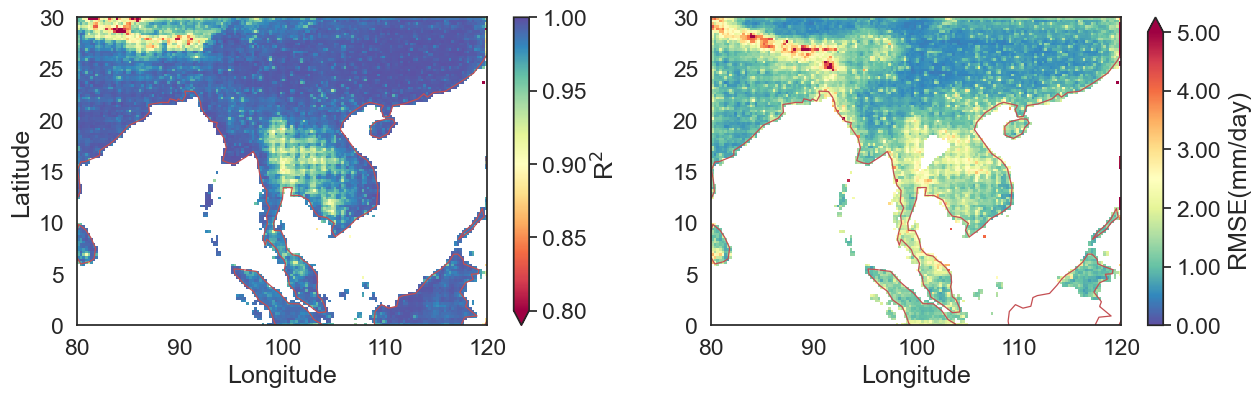

In [24]:
# calculate rmse for test dataset
import seaborn as sns
sns.set(font_scale=1.5, style='white')
import xskillscore as xs
unscaled_test= y_scaler_test.inverse_transform(unscaled_preds['test'])*86400
unscaled_test =xr.DataArray(unscaled_test, 
coords={'lat': output_ds[0].lat,'lon': output_ds[0].lon,'time': y_test.time}, 
dims=["time", "lat", "lon"])
 
pr_test =y_scaler_test.inverse_transform(y_test[:,:,:,0])*86400
pr_test

rmse_test = xs.rmse(pr_test, unscaled_test, dim= 'time')
Rsq_test = xr.corr(pr_test, unscaled_test, dim='time')

fig, (ax1, ax2)= plt.subplots(figsize=(15,4), ncols=2)
Rsq_test.plot(vmax=1, vmin= 0.8, cmap= 'Spectral', cbar_kwargs= {'label': 'R$^2$', 'format': '%.2f'}, ax= ax1)
rmse_test.plot(vmax= 5, vmin= 0, cmap= 'Spectral_r', cbar_kwargs= {'label': 'RMSE(mm/day)', 'format': '%.2f'}, ax= ax2)
ax1.set_xlabel('Longitude')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('')
ax1.set_ylabel('Latitude')
[df.plot(ax=ax, facecolor='None', edgecolor= 'r', linewidth= 0.9) for ax in [ax1, ax2]]
plt.savefig('stats for test.png', dpi=600, bbox_inches='tight')
#ecv.plot((rmse_test,Rsq_test), show_coastline=True, global_extent=False, subplot_titles=('RMSE (mm/day)', 'R$^2$'))

In [25]:
#Combine all training, valid and test and compare with bias corrected plots

unscaled_preds_da = xr.concat([xr.DataArray(unscaled_array[:,:,:,0], 
coords={'lat': output_ds[0].lat,'lon': output_ds[0].lon,'time': y_name.time}, 
dims=["time", "lat", "lon"]) for unscaled_array, y_name in zip(unscaled_preds.values(), [y_train, y_valid, y_test])], dim='time')

# inverse transform
output_scaler=  dds.StandardScaler(axis=None)
output_scaler.fit(output_ds[0])
unscaled_preds_da = output_scaler.inverse_transform(unscaled_preds_da) * 86400
unscaled_preds_da= unscaled_preds_da.sortby('time')

In [26]:
# Preprocess data to fit for climate indices calculations
aphrodite= output_ds[0]*86400
aphrodite.attrs['units']= 'mm/day'
bsc_ecearth = xr.open_dataset('bcs_ece.nc').pr
bsc_ecearth.attrs['units']= 'mm/day'
bsc_ecearth= bsc_ecearth.sortby('time')
bsc_ecearth['time']=pd.date_range('1985-01-01', '2014-12-31')

downscaled_ecearth = unscaled_preds_da.copy()
downscaled_ecearth['time']=pd.date_range('1985-01-01', '2014-12-31')
downscaled_ecearth.attrs['units'] = 'mm/day'


In [ ]:
downscaled_ecearth.to_netcdf('Ds_ecearth.nc')

In [27]:
# compute RMSE and corr for both bias corrected and downscaled precpitation and make plots
rmse_bcdata = xs.rmse(aphrodite, bsc_ecearth, dim= 'time')
r2_bcdata = xr.corr(aphrodite, bsc_ecearth, dim= 'time')

#rmse and r2 for downscaled ecearth
rmse_dsdata = xs.rmse(aphrodite, downscaled_ecearth, dim= 'time')
r2_dsdata = xr.corr(aphrodite, downscaled_ecearth, dim= 'time')



Text(0.5, 60.249999999999986, 'Longitude')

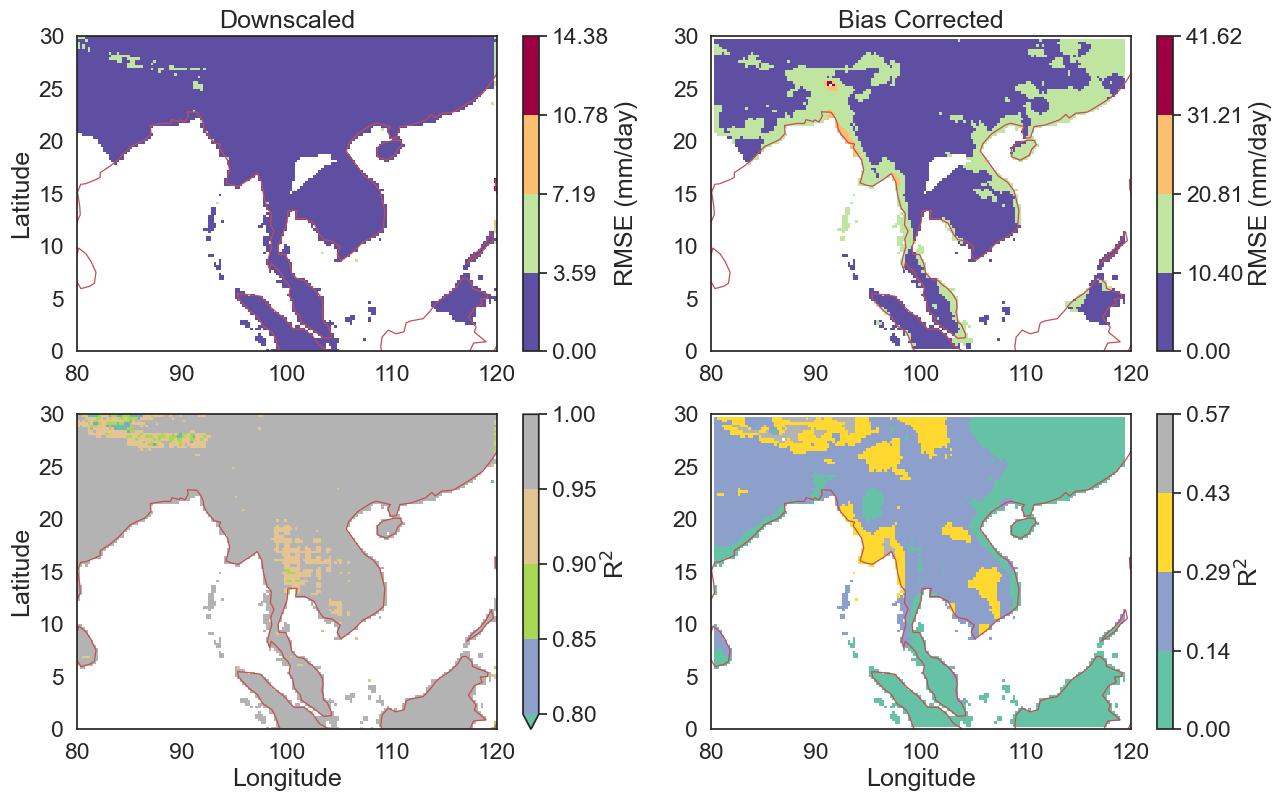

In [28]:
# plot rmse and r2
#ecv.plot((r2_bcdata, r2_dsdata, rmse_bcdata, rmse_dsdata), subplot_titles=('R$^2$','R$^2$', 'RMSE', 'RMSE'), col_wrap=2)
fig, ((ax1, ax2), (ax3, ax4))= plt.subplots(figsize= (15,9), ncols=2, nrows=2)

#rmse for downscaled data
rmse_dsdata.plot( vmin=0, levels= 5,cmap= 'Spectral_r', cbar_kwargs= {'label': 'RMSE (mm/day)', 'format':'%.2f'}, ax= ax1)
df.plot(ax=ax1, facecolor='None', edgecolor= 'r', linewidth= 0.9)
ax1.set_ylabel('Latitude')
ax1.set_xlabel('')
ax1.set_title ('Downscaled')


# rmse for biascorrected data
rmse_bcdata.plot( vmin=0, levels= 5,cmap= 'Spectral_r', cbar_kwargs= {'label': 'RMSE (mm/day)', 'format':'%.2f'}, ax= ax2)
df.plot(ax=ax2, facecolor='None', edgecolor= 'r', linewidth= 0.9)
ax2.set_ylabel('')
ax2.set_xlabel('')
ax2.set_title('Bias Corrected')

#r2 of ds data
r2_dsdata.plot( vmin=0.8, levels= 5,cmap= 'Set2', cbar_kwargs= {'label':'R$^2$', 'format':'%.2f'}, ax= ax3)
df.plot(ax=ax3, facecolor='None', edgecolor= 'r', linewidth= 0.9)
ax3.set_ylabel('Latitude')
ax3.set_xlabel('Longitude')

#r2 of BC data
r2_bcdata.plot( vmin=0, levels= 5,cmap= 'Set2', cbar_kwargs= {'label': 'R$^2$', 'format':'%.2f'}, ax= ax4)
df.plot(ax=ax4, facecolor='None', edgecolor= 'r', linewidth= 0.9)
ax4.set_ylabel('')
ax4.set_xlabel('Longitude')

#plt.savefig('RMSE_R2 comparison between DS and BS data.png', dpi=600, bbox_inches='tight')

In [30]:
#import libraries to compute extreme indices
import warnings
warnings.filterwarnings("ignore")
import xclim as xc

from xclim.indices import maximum_consecutive_dry_days as CDD
from xclim.indices import maximum_consecutive_wet_days as CWD
from xclim.indices import wetdays
from xclim.indices import days_over_precip_thresh as rxp

In [31]:
# Clip to Namngum extent and compute extreme climate indices
aphro_nam = (aphrodite.rio.write_crs(4326)
             .rename({'lat':'y', 'lon':'x'})
             .rio.clip(namngum.geometry, all_touched= True)
             .rename({'y':'lat', 'x':'lon'})
            )
bc_nam = (bsc_ecearth.rio.write_crs(4326)
             .rename({'lat':'y', 'lon':'x'})
             .rio.clip(namngum.geometry, all_touched= True)
             .rename({'y':'lat', 'x':'lon'})
            )
ds_nam = (downscaled_ecearth.rio.write_crs(4326)
             .rename({'lat':'y', 'lon':'x'})
             .rio.clip(namngum.geometry, all_touched= True)
             .rename({'y':'lat', 'x':'lon'})
              
            )

#bc_nam = bsc_ecearth.rio.write

Text(0, 0.5, 'Precipitation (mm)')

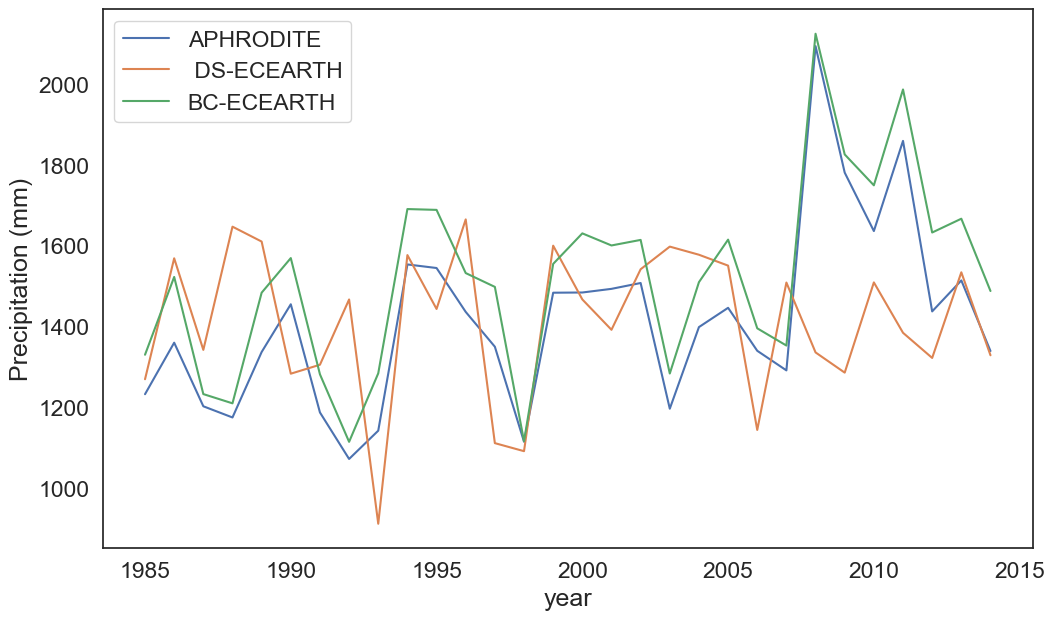

In [32]:
# plto yearly average
plt.figure(figsize=(12, 7))
for label, dataar in zip(['APHRODITE',' DS-ECEARTH', 'BC-ECEARTH'],[aphro_nam, bc_nam, ds_nam]):
    plotda=dataar.groupby('time.year').sum(skipna=False).mean(dim=('lat', 'lon'))
    sns.lineplot(x= plotda.year, y= plotda.values, label= label)
plt.ylabel('Precipitation (mm)')
#plt.savefig('./Annual precipitation variation among three dataset.png', dpi= 300)

In [33]:
# compute extreme indices along with annual precipitation, seasonal precipitation
# label indices and provide threshold
indices_names= ['CDD', 'CWD', 'R10mm', 'R20mm', 'R95p', 'R99p']
threshold = [1, 1, 10, 20, 0.95, 0.99]

# compute and plot
models_indices={}

for name, ds in zip(['APHRODITE','BC_ECEARTH', 'DS_ECEARTH'], [aphro_nam,bc_nam, ds_nam]):
    model_indices={}
    for iname, thresh in zip(indices_names, threshold):
        if iname in ['CDD', 'CWD']:
            model_indices[iname] = eval(iname)(ds, thresh)
        elif iname in ['R10mm', 'R20mm']:
            model_indices[iname] = wetdays(ds, thresh)
        else:
            percentile = ds.quantile(thresh, dim='time', keep_attrs=True)
            model_indices[iname] = rxp(ds, percentile)
    models_indices[name]= model_indices
        
#models_indices

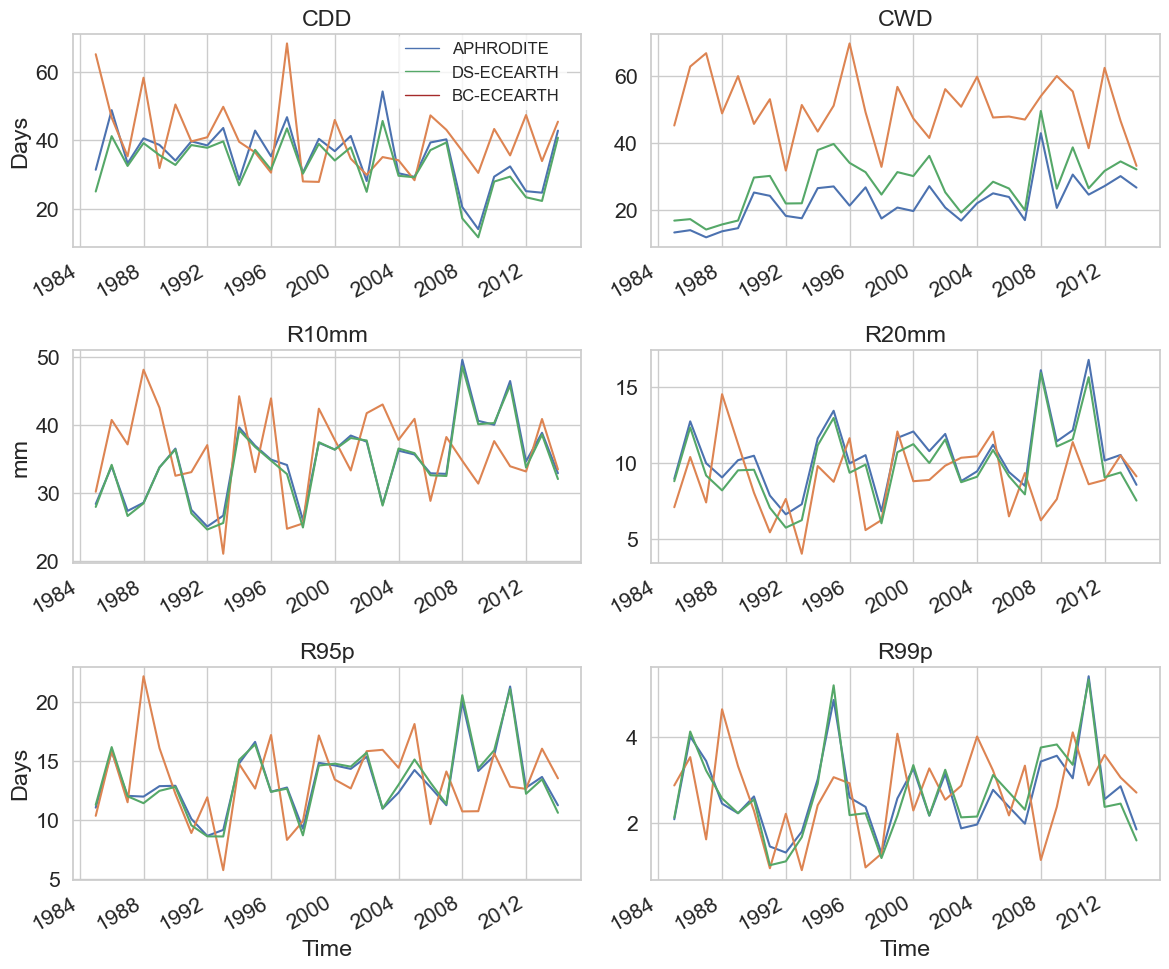

In [35]:
#plot extreme indices and compute basin average
units = ['Days', '', 'mm', '', 'Days', '']
sns.set(style= 'whitegrid', font_scale=1.4)
avg_models_indices = {model : {indice : da.mean(dim=('lat','lon')) for indice, da in da_indices.items()}
                      for model, da_indices in models_indices.items()}


#plot
fig, axes= plt.subplots(figsize=(12,10), ncols=2, nrows=3)

for i, ax in enumerate(axes.flatten()):
    handles = []
    for model, da  in avg_models_indices.items():
        line=da[indices_names[i]].drop('spatial_ref').plot(label = model, ax=ax)
        handles.append(line)
    ax.set_title(indices_names[i])
    ax.set_ylabel(units[i])
    #ax.set_xticks(np.arange(1985, 2014,1))
    [ax.set_xlabel('Time') if i >=4 else ax.set_xlabel('')]
    
   
plt.tight_layout()

# create custom handles
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='b', lw=1),
                Line2D([0], [0], color='g', lw=1),
                Line2D([0], [0], color='brown', lw=1)]
plt.legend(custom_lines, ['APHRODITE', 'DS-ECEARTH', 'BC-ECEARTH'], bbox_to_anchor=[-0.35,3.8, 0.2, 0.2], fontsize=12, edgecolor= 'None')
#plt.legend(handles, avg_models_indices.keys() )
#plt.savefig('Extreme Indices comparison between APHRODITE, BC and DS data.png', dpi=600, bbox_inches='tight')

In [36]:
ind_keys= list(avg_models_indices.values())[0].keys()
avg_indices= {i: {o: avg_models_indices[o][i] for o in avg_models_indices} for i in ind_keys}
rmse_ind = pd.concat({ind :pd.DataFrame.from_dict({ model: xs.rmse(da1['APHRODITE'], ds, dim='time').values
             for model, ds in da1.items()}, orient='index').T 
            for ind, da1 in avg_indices.items()}, axis=0)
#rmse_ind.to_excel('./Indicewise rmse.xlsx')


In [37]:
# compute bias between long term precipitaion of predicted and aphrodite

longterm_pred =unscaled_preds_da.groupby('time.year').sum(dim='time', skipna=True)#.mean(dim='year', skipna=True,)
longterm_obs =(output_ds[0]*86400).groupby('time.year').sum(dim='time', skipna=True)#.mean(dim='year', skipna=True,)
bias = longterm_obs - longterm_pred

# fig, (ax1, ax2, ax3) = plt.subplots (figsize= (16,6), ncols = 3)
# longterm_pred.sel(lon= slice(85, 115), lat=slice(5,28)).plot(ax= ax1)
# longterm_obs.sel(lon= slice(85, 115), lat=slice(5,28)).plot(ax= ax2)
# bias.sel(lon= slice(85, 115), lat=slice(5,25)).plot(vmin=-300,vmax= 300, ax=ax3)

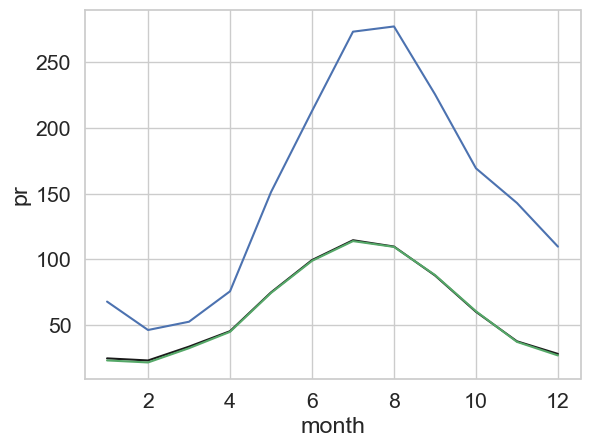

In [38]:

    (unscaled_preds_da.groupby('time.month').sum(dim='time', skipna=True)/30).mean(dim= ['lat', 'lon']).plot(c='k')
    ((output_ds[0]*86400).groupby('time.month').sum(dim='time', skipna=True)/30).mean(dim= ['lat', 'lon']).plot(c='g')
    ((pred_ds['pr'][0]*86400).groupby('time.month').sum()/30).mean(dim= ['lat', 'lon']).plot(label='raw')

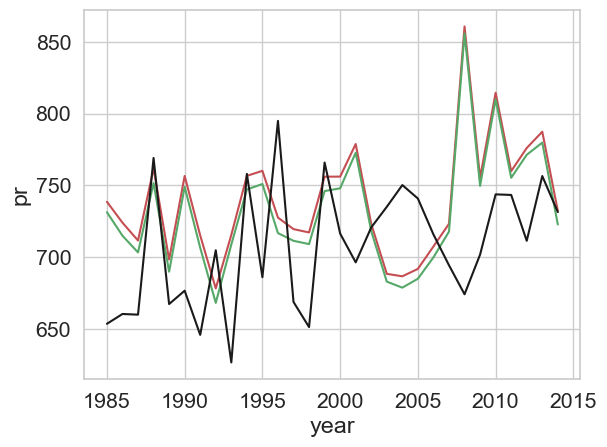

In [39]:
    (unscaled_preds_da.groupby('time.year').sum(dim='time', skipna=True)).mean(dim= ['lat', 'lon']).plot(c='r')
    ((output_ds[0]*86400).groupby('time.year').sum(dim='time', skipna=True)).mean(dim= ['lat', 'lon']).plot(c='g')
    (bsc_ecearth.groupby('time.year').sum(dim='time', skipna=True)).mean(dim= ['lat', 'lon']).plot(c='k')
    #((pred_ds['pr'][0]*86400).groupby('time.year').sum()).mean(dim= ['lat', 'lon']).plot(c='b')